# NASICON kMCpy Tutorial

This notebook demonstrates key steps in the kinetic Monte Carlo (KMC) simulation workflow for NASICON (Na Super Ionic Conductor) materials using the kMCpy library. The examples cover event generation, cluster expansion setup, energy parameter fitting, running a complete KMC simulation, and managing parameter studies.

**Sections:**
1. Event Generation for Ionic Motion
2. Local Cluster Expansion Setup
3. Energy Parameter Fitting
4. Complete KMC Simulation Workflow
5. Parameter Studies and Workflow Management

## Installation

In [1]:
!pip install kmcpy

## 1. Event Generation for Ionic Motion

Generate hopping events for Na⁺ ions in NASICON using kMCpy's `EventGenerator`. This step defines all possible ionic jumps in the simulation, ensuring realistic modeling of ionic transport.

**Key steps:**
- Specify mobile ion identifiers and structure file paths
- Set environment cutoffs for neighbor analysis
- Generate events for both supercell and primitive cell configurations

In [15]:
from kmcpy.event import EventGenerator
import os

# Define file paths and parameters
file_path = f"{os.getcwd()}/files"
structure_file = f"{file_path}/nasicon.cif"
mobile_ion_identifier_type = "label"
mobile_ion_identifiers = ("Na1", "Na2")
local_env_cutoff_dict = {("Na+", "Na+"): 4, ("Na+", "Si4+"): 4}

# Create EventGenerator instance
generator = EventGenerator()

# Generate events for supercell configuration
generator.generate_events(
    structure_file=structure_file,
    local_env_cutoff_dict=local_env_cutoff_dict,
    mobile_ion_identifier_type=mobile_ion_identifier_type,
    mobile_ion_identifiers=mobile_ion_identifiers,
    species_to_be_removed=["O2-", "O", "Zr4+", "Zr"],
    distance_matrix_rtol=0.01,
    distance_matrix_atol=0.01,
    find_nearest_if_fail=False,
    convert_to_primitive_cell=False,
    export_local_env_structure=True,
    supercell_shape=[2, 1, 1],
    event_file=f"{file_path}/events.json",
    event_dependencies_file=f"{file_path}/event_dependencies.csv",
)

from kmcpy.event import EventLib

event_lib = EventLib.from_json(f"{file_path}/events.json")
print(f"Number of unique local environment types: {len(event_lib.events)}")

print(f"Event dependency: {event_lib.get_dependency_statistics()}")

Number of unique local environment types: 72
Event dependency: {'total_events': 72, 'total_dependencies': 2160, 'max_dependencies_per_event': 30, 'min_dependencies_per_event': 30, 'avg_dependencies_per_event': 30.0, 'dependency_density': 0.4166666666666667}


## 2. Local Cluster Expansion Setup

Build a local cluster expansion (LCE) model for NASICON to enable fast energy calculations during KMC simulations.

**Key steps:**
- Load the NASICON structure
- Define the local lattice structure and basis functions
- Build and save the cluster expansion model

In [16]:
from kmcpy.models.local_cluster_expansion import LocalClusterExpansion
from kmcpy.structure.local_lattice_structure import LocalLatticeStructure
from kmcpy.external.structure import StructureKMCpy

# Load NASICON primitive structure
structure = StructureKMCpy.from_cif(
    filename=f"{file_path}/nasicon.cif",
    primitive=True
)
print(f"Loaded NASICON primitive structure with {len(structure)} atoms.")

# Define local lattice structure around Na site 0
local_lattice_structure = LocalLatticeStructure(
    template_structure=structure,
    center=0,
    cutoff=4.0,
    specie_site_mapping={
        "Na": ["Na", "X"],    # Na or vacancy
        "Zr": "Zr",
        "Si": ["Si", "P"],
        "O": "O"
    },
    basis_type="chebyshev",
    is_write_basis=True,
    exclude_species=["O2-", "O", "Zr4+", "Zr"]
)
print("Local lattice structure created.")

# Build cluster expansion model
cluster_expansion = LocalClusterExpansion()
cluster_expansion.build(
    local_lattice_structure=local_lattice_structure,
    mobile_ion_identifier_type="label",
    mobile_ion_specie_identifier="Na1",
    cutoff_cluster=[6, 6, 0],  # 2-body and 3-body clusters
    cutoff_region=5,
    convert_to_primitive_cell=True,
)
print("Cluster expansion built.")

# Save cluster expansion model to file
output_file = f"{file_path}/lce.json"
cluster_expansion.to_json(output_file)
print(f"Cluster expansion saved to: {output_file}")

Loaded NASICON primitive structure with 42 atoms.
Local lattice structure created.
Cluster expansion built.
Cluster expansion saved to: /home/jerry/work/kMCpy/example/files/lce.json


## 3. Energy Parameter Fitting

Fit cluster expansion parameters to reference energy data using kMCpy's `LCEFitter` class. This step ensures accurate energy predictions for KMC simulations.

**Key steps:**
- Load input files (energy data, weights, correlations)
- Run the fitting procedure with regularization
- Calculate fitting statistics and validate results

In [7]:
from kmcpy.models.local_cluster_expansion import LocalClusterExpansion
import numpy as np

# Run energy parameter fitting
_, y_predicted, y_true = LocalClusterExpansion().fit(
    alpha=1.5,
    max_iter=1000000,
    ekra_fname=f"{file_path}/local_cluster_expansion/e_kra.txt",
    keci_fname=f"{file_path}/local_cluster_expansion/keci.txt",
    weight_fname=f"{file_path}/local_cluster_expansion/weight.txt",
    corr_fname=f"{file_path}/local_cluster_expansion/correlation_matrix.txt",
    fit_results_fname=f"{file_path}/fitting_results.json",
)
print("EKRA fitting completed.")

# Calculate fitting statistics
residuals = y_predicted - y_true
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(np.abs(residuals))
max_error = np.max(np.abs(residuals))

print(f"Fitting quality metrics:")
print(f"  - RMSE: {rmse:.4f} meV")
print(f"  - MAE:  {mae:.4f} meV")
print(f"  - Max error: {max_error:.4f} meV")
print(f"  - Data points: {len(y_true)}")

# Validate fitting quality
fitting_quality = np.allclose(y_predicted, y_true, rtol=0.3, atol=10.0)
print("Fitting quality: GOOD" if fitting_quality else "⚠ Fitting quality: NEEDS ATTENTION")

# Run energy parameter fitting
_, y_predicted, y_true = LocalClusterExpansion().fit(
    alpha=1.5,
    max_iter=1000000,
    ekra_fname=f"{file_path}/local_cluster_expansion_site/e_site.txt",
    keci_fname=f"{file_path}/local_cluster_expansion_site/keci.txt",
    weight_fname=f"{file_path}/local_cluster_expansion_site/weight.txt",
    corr_fname=f"{file_path}/local_cluster_expansion_site/correlation_matrix.txt",
    fit_results_fname=f"{file_path}/fitting_results_site.json",
)
print("\nEsite fitting completed.")

# Calculate fitting statistics
residuals = y_predicted - y_true
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(np.abs(residuals))
max_error = np.max(np.abs(residuals))

print(f"Fitting quality metrics:")
print(f"  - RMSE: {rmse:.4f} meV")
print(f"  - MAE:  {mae:.4f} meV")
print(f"  - Max error: {max_error:.4f} meV")
print(f"  - Data points: {len(y_true)}")

# Validate fitting quality
fitting_quality = np.allclose(y_predicted, y_true, rtol=0.3, atol=10.0)
print("Fitting quality: GOOD" if fitting_quality else "⚠ Fitting quality: NEEDS ATTENTION")

EKRA fitting completed.
Fitting quality metrics:
  - RMSE: 9.2399 meV
  - MAE:  7.0325 meV
  - Max error: 24.8008 meV
  - Data points: 15
Fitting quality: GOOD

Esite fitting completed.
Fitting quality metrics:
  - RMSE: 8.3625 meV
  - MAE:  5.6658 meV
  - Max error: 27.0991 meV
  - Data points: 15
Fitting quality: GOOD


## 4. Complete KMC Simulation Workflow

Run a full kinetic Monte Carlo simulation using `SimulationConfig` and `KMC` classes. Analyze transport properties such as diffusivity and conductivity.

**Key steps:**
- Create simulation configuration with all required files and parameters
- Run the KMC simulation
- Analyze and validate transport properties

In [17]:
from kmcpy.simulator.config import SimulationConfig
from kmcpy.simulator.kmc import KMC

import numpy as np
import os

import logging

## for more detailed information, we set the logging level to DEBUG
logging.basicConfig(
    level=logging.INFO, # Set to DEBUG to see everything
    format='%(asctime)s - %(name)-28s - %(levelname)-8s - %(message)s',
    datefmt='%Y-%m-%d %H:%M',
    filename='output.log',  # Log to a file named output.log
    filemode='w',  # Overwrite the log file each time
)

# Set up simulation configuration
config = SimulationConfig.create(
    structure_file=f"{file_path}/nasicon.cif",
    cluster_expansion_file=f"{file_path}/input/lce.json",
    fitting_results_file=f"{file_path}/input/fitting_results.json",
    cluster_expansion_site_file=f"{file_path}/input/lce.json",
    fitting_results_site_file=f"{file_path}/input/fitting_results_site.json",
    event_file=f"{file_path}/input/events.json",
    initial_state_file=f"{file_path}/input/initial_state.json",
    mobile_ion_specie="Na",
    temperature=298,
    attempt_frequency=5e12,
    elementary_hop_distance=3.47782,
    equilibration_passes=10,
    kmc_passes=1000,
    supercell_shape=(2, 1, 1),
    immutable_sites=("Zr", "O", "Zr4+", "O2-"),
    convert_to_primitive_cell=True,
    random_seed=12345,
    name="NASICON_KMC"
)

# Run KMC simulation
kmc = KMC.from_config(config)
kmc_tracker = kmc.run(config)
results = kmc_tracker.return_current_info()
print("KMC simulation completed.")
print("Simulation Results:")

if len(results) >= 7:
    time, temperature, diffusivity, conductivity, msd, correlation_factor, tracer_diffusivity = results[:7]
    print(f"  - Simulation time: {time:.2e} s")
    print(f"  - Temperature: {temperature:.1f} K")
    print(f"  - Diffusivity: {diffusivity:.2e} cm2/s")
    print(f"  - Conductivity: {conductivity:.2e} S/cm")
    print(f"  - MSD: {msd:.2e}")
    print(f"  - Correlation factor: {correlation_factor:.3f}")
    print(f"  - Tracer diffusivity: {tracer_diffusivity:.2e} cm2/s")
else:
    print(f"Results vector has {len(results)} elements (expected 7)")

KMC simulation completed.
Simulation Results:
  - Simulation time: 1.30e-05 s
  - Temperature: 3702.0 K
  - Diffusivity: 1.19e-08 cm2/s
  - Conductivity: 4.75e-09 S/cm
  - MSD: 9.61e-01
  - Correlation factor: 0.399
  - Tracer diffusivity: 2.71e-01 cm2/s


In [11]:
!gunzip *.gz

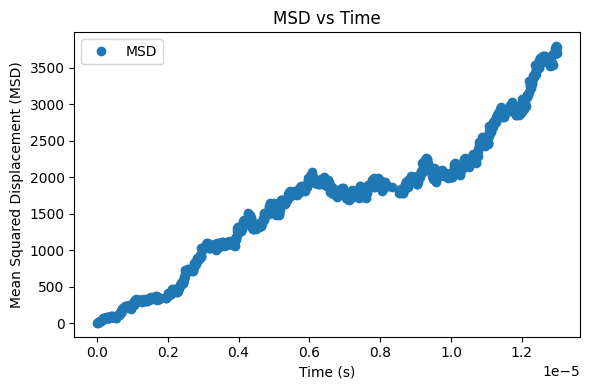

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('results_NASICON_KMC.csv')

plt.figure(figsize=(6, 4))
plt.plot(data['time'], data['msd'], 'o', label='MSD')
plt.xlabel('Time (s)')
plt.ylabel('Mean Squared Displacement (MSD)')
plt.title('MSD vs Time')
plt.legend()
plt.tight_layout()
plt.show()

## Show results

In [13]:
!cat results_NASICON_KMC.csv

time,D_J,D_tracer,conductivity,f,H_R,msd
1.4114491554783589e-08,2.0446961617347386e-08,8.161287941008301e-09,1.6524504026701266,0.4761894198178719,0.3991442882195363,6.911545783171129
2.936023890949216e-08,1.0556746700981126e-09,5.0539113048983535e-09,0.08531585603468204,0.3530669188003528,4.787375739941408,8.903042600351936
3.6516124429940154e-08,2.6992536174190527e-09,7.914449556014898e-09,0.2181440357978997,0.3416035167135793,2.932088153903249,17.340301486915475
4.652491037321188e-08,2.006702568569693e-09,6.427544123272177e-09,0.16217453377810728,0.3666551581399694,3.203037771488729,17.94245485530617
6.045372706393715e-08,5.826919705682206e-09,7.069095643945454e-09,0.4709108372273749,0.33220526738046846,1.213178832214201,25.641190718876732
7.735253743090545e-08,6.960714330145137e-09,5.948182801481799e-09,0.5625400689343228,0.3074860001604859,0.8545362615617892,27.606421967849336
9.347986321434334e-08,1.0109638556300205e-08,6.458459225322442e-09,0.8170248771355086,0.3330260740521474,